# DCGAN with MNIST (or Fashion MNIST)

* `Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks`, [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
  * Alec Radford, Luke Metz and Soumith Chintala
  
* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)
* Use `transposed_conv2d` and `conv2d` for Generator and Discriminator, respectively.
  * I do not use `dense` layer for model architecture consistency. (So my architecture is different from original dcgan structure)
  
* This code refers to [TensorFlow official tutorial dcgan code](https://www.tensorflow.org/alpha/tutorials/generative/dcgan).

## 1. Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages

## 2. Setting hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'dcgan'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'mnist'
assert dataset_name in ['mnist', 'fashion_mnist']
max_epochs = 50
save_model_epochs = 10
print_steps = 100
save_images_epochs = 1
batch_size = 256
learning_rate_D = 1e-4
learning_rate_G = 1e-4
k = 1 # the number of step of learning D before learning G (Not used in this code)
num_examples_to_generate = 25
noise_dim = 100

## 3. Load the MNIST dataset

In [3]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), _ = \
      tf.keras.datasets.mnist.load_data()
else:
  (train_images, train_labels), _ = \
      tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
#train_images = train_images / 255. # Normalize the images to [0, 1]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

## 4. Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
#tf.random.set_seed(219)
# for train
N = len(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


## 5. Create the generator and discriminator models

In [5]:
class Conv(tf.keras.Model):
  def __init__(self, filters, kernel_size, strides, padding='same',
               apply_batchnorm=True, activation='relu'):
    super(Conv, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    assert activation in ['relu', 'leaky_relu', 'none']
    self.activation = activation
        
    self.conv = layers.Conv2D(filters=filters,
                              kernel_size=(kernel_size, kernel_size),
                              strides=strides,
                              padding=padding,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02),
                              use_bias=not self.apply_batchnorm)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization()
  
  def call(self, x, training=True):
    '''
    빈칸 채우기 시작
    '''
    # convolution
    # self.conv를 호출해 input x에 convolution operation을 적용합니다.
    
    x = #빈칸#
    
    # batchnorm
    if self.apply_batchnorm:
      # self.batchnorm을 호출해 input x에 batch normalization을 적용합니다. 단, training시 training flag에 True를 입력시킵니다.
      # 참고 : https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization 
      x = self.batchnorm(x, training=training)
    
    # activation
    # self.activation이 'relu'값인 경우, tf.nn.relu를 이용해 Rectified Linear Unit Activation을 적용합니다.
    # self.activation이 'leaky_relu'값인 경우, tf.nn.leaky_relu를 이용해 Leaky Rectified Linear Unit Activation을 적용합니다.
    
    if self.activation == #빈칸#:
      x = #빈칸#
    elif self.activation == #빈칸#:
      x = #빈칸#
    
    '''
    빈칸 채우기 끝
    '''
    
    return x

In [6]:
class ConvTranspose(tf.keras.Model):
  def __init__(self, filters, kernel_size, padding='same',
               apply_batchnorm=True, activation='relu'):
    super(ConvTranspose, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    assert activation in ['relu', 'sigmoid', 'tanh']
    self.activation = activation
    self.up_conv = layers.Conv2DTranspose(filters=filters,
                                          kernel_size=(kernel_size, kernel_size),
                                          strides=2,
                                          padding=padding,
                                          kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                          use_bias=not self.apply_batchnorm)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization()

  def call(self, x, training=True):
    # conv transpose
    x = self.up_conv(x)
    
    # batchnorm
    if self.apply_batchnorm:
      x = self.batchnorm(x, training=training)
      
    # activation
    if self.activation == 'relu':
      x = tf.nn.relu(x)
    elif self.activation == 'sigmoid':
      x = tf.nn.sigmoid(x)
    else:
      x = tf.nn.tanh(x)
    
    return x

In [7]:
class Generator(tf.keras.Model):
  """Build a generator that maps latent space to real space.
    G(z): z -> x
  """
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = ConvTranspose(256, 3, padding='valid')
    self.conv2 = ConvTranspose(128, 3, padding='valid')
    self.conv3 = ConvTranspose(64, 4)
    self.conv4 = ConvTranspose(1, 4, apply_batchnorm=False, activation='tanh')

  def call(self, inputs, training=True):
    """Run the model."""
    # inputs: [1, 1, 100]
    conv1 = self.conv1(inputs, training=training)           # conv1: [3, 3, 256]
    conv2 = self.conv2(conv1, training=training)            # conv2: [7, 7, 128]
    conv3 = self.conv3(conv2, training=training)            # conv3: [14, 14, 64]
    generated_images = self.conv4(conv3, training=training) # generated_images: [28, 28, 1]
    
    return generated_images

In [8]:
class Discriminator(tf.keras.Model):
  """Build a discriminator that discriminate real image x whether real or fake.
    D(x): x -> [0, 1]
  """
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = Conv(64, 4, 2, apply_batchnorm=False, activation='leaky_relu')
    self.conv2 = Conv(128, 4, 2, activation='leaky_relu')
    self.conv3 = Conv(256, 3, 2, padding='valid', activation='leaky_relu')
    self.conv4 = Conv(1, 3, 1, padding='valid', apply_batchnorm=False, activation='none')

  def call(self, inputs, training=True):
    """Run the model."""
    # inputs: [28, 28, 1]
    conv1 = self.conv1(inputs)                            # conv1: [14, 14, 64]
    conv2 = self.conv2(conv1)                             # conv2: [7, 7, 128]
    conv3 = self.conv3(conv2)                             # conv3: [3, 3, 256]
    conv4 = self.conv4(conv3)                             # conv4: [1, 1, 1]
    discriminator_logits = tf.squeeze(conv4, axis=[1, 2]) # discriminator_logits: [1,]
    
    return discriminator_logits

In [9]:
generator = Generator()
discriminator = Discriminator()

### Plot generated image via generator network

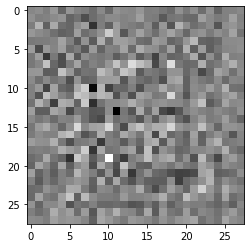

In [10]:
noise = tf.random.normal([1, 1, 1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Test discriminator network

* **CAUTION**: the outputs of discriminator is **logits** (unnormalized probability) NOT probabilites

In [11]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.03966308]], shape=(1, 1), dtype=float32)


## 6. Define the loss functions and the optimizer

In [12]:
# use logits for consistency with previous code I made
# `tf.losses` and `tf.keras.losses` are the same API (alias)
bce = tf.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def GANLoss(logits, is_real=True):
  """Computes standard GAN loss between `logits` and `labels`.

  Args:
    logits (`2-rank Tensor`): logits.
    is_real (`bool`): True means `1` labeling, False means `0` labeling.

  Returns:
    loss (`0-rank Tensor`): the standard GAN loss value. (binary_cross_entropy)
  """
  if is_real:
    labels = tf.ones_like(logits)
  else:
    labels = tf.zeros_like(logits)

  #return tf.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=logits)
  return bce(labels, logits)

In [14]:
def discriminator_loss(real_logits, fake_logits):
  # losses of real with label "1"
  real_loss = GANLoss(logits=real_logits, is_real=True)
  # losses of fake with label "0"
  fake_loss = GANLoss(logits=fake_logits, is_real=False)
  
  return real_loss + fake_loss

In [15]:
def generator_loss(fake_logits):
  # losses of Generator with label "1" that used to fool the Discriminator
  return GANLoss(logits=fake_logits, is_real=True)

In [16]:
#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate_D, beta1=0.5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate_D)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate_G, beta_1=0.5)

## 7. Checkpoints (Object-based saving)

In [17]:
checkpoint_dir = train_dir
if not tf.io.gfile.exists(checkpoint_dir):
  tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 8. Training

In [18]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
# To visualize progress in the animated GIF
const_random_vector_for_saving = tf.random.uniform([num_examples_to_generate, 1, 1, noise_dim],
                                                   minval=-1.0, maxval=1.0)

In [19]:
def print_or_save_sample_images(sample_images, max_print_size=num_examples_to_generate,
                                is_square=False, is_save=False, epoch=None,
                                checkpoint_dir=checkpoint_dir):
  available_print_size = list(range(1, 26))
  assert max_print_size in available_print_size
  
  if not is_square:
    print_images = sample_images[:max_print_size, ...]
    print_images = print_images.reshape([max_print_size, 28, 28])
    print_images = print_images.swapaxes(0, 1)
    print_images = print_images.reshape([28, max_print_size * 28])

    fig = plt.figure(figsize=(max_print_size, 1))
    plt.imshow(print_images, cmap='gray')
    plt.axis('off')
    
  else:
    num_columns = int(np.sqrt(max_print_size))
    max_print_size = int(num_columns**2)
    print_images = sample_images[:max_print_size, ...]
    print_images = print_images.reshape([max_print_size, 28, 28])
    print_images = print_images.swapaxes(0, 1)
    print_images = print_images.reshape([28, max_print_size * 28])
    print_images = [print_images[:,i*28*num_columns:(i+1)*28*num_columns] for i in range(num_columns)]
    print_images = np.concatenate(tuple(print_images), axis=0)
    
    fig = plt.figure(figsize=(num_columns, num_columns))
    plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0)
    plt.imshow(print_images, cmap='gray')
    plt.axis('off')
    
  if is_save and epoch is not None:
    filepath = os.path.join(checkpoint_dir, 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.savefig(filepath)

  plt.show()

### Define training one step function

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  # generating noise from a uniform distribution
  noise = tf.random.uniform([batch_size, 1, 1, noise_dim], minval=-1.0, maxval=1.0)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_logits = discriminator(images, training=True)
    fake_logits = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_logits)
    disc_loss = discriminator_loss(real_logits, fake_logits)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss, disc_loss

### Train full steps

Epochs: 7.66 global_step: 1800 loss_D: 0.525 loss_G: 1.72 (21995.24 examples/sec; 0.012 sec/batch)
(25, 28, 28, 1)


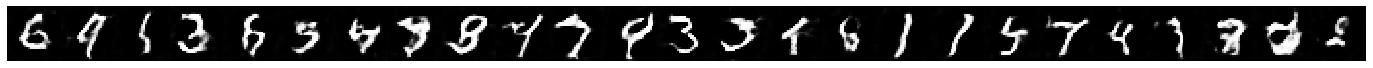

E0828 23:10:22.909080 140152109279040 ultratb.py:155] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-6375083bba1f>", line 10, in <module>
    gen_loss, disc_loss = train_step(images)
  File "/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 404, in __call__
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 1335, in __call__
    return graph_function._filtered_call(args, kwargs)  # pylint: disable=protected-access
  File "/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 589, in _filtered_call
    (t for t in nest.flatten((args, kwargs), expand_composites=True)
  File "/home/scpark/anaconda3/envs/ai/lib/python

KeyboardInterrupt: 

In [21]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)

for epoch in range(max_epochs):
  
  for step, images in enumerate(train_dataset):
    start_time = time.time()
    
    gen_loss, disc_loss = train_step(images)
    global_step.assign_add(1)
    
    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} loss_D: {:.3g} loss_G: {:.3g} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), disc_loss, gen_loss, examples_per_sec, duration))
      random_vector_for_sampling = tf.random.uniform([num_examples_to_generate, 1, 1, noise_dim],
                                                     minval=-1.0, maxval=1.0)
      sample_images = generator(random_vector_for_sampling, training=False)
      print(sample_images.shape)
      print_or_save_sample_images(sample_images.numpy())

  if (epoch + 1) % save_images_epochs == 0:
    display.clear_output(wait=True)
    print("This images are saved at {} epoch".format(epoch+1))
    sample_images = generator(const_random_vector_for_saving, training=False)
    print_or_save_sample_images(sample_images.numpy(), is_square=True,
                                is_save=True, epoch=epoch+1,
                                checkpoint_dir=checkpoint_dir)

  # saving (checkpoint) the model every save_epochs
  if (epoch + 1) % save_model_epochs == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)
    
print('Training Done.')

In [ ]:
# generating after the final epoch
display.clear_output(wait=True)
sample_images = generator(const_random_vector_for_saving, training=False)
print_or_save_sample_images(sample_images.numpy(), is_square=True,
                            is_save=True, epoch=epoch+1,
                            checkpoint_dir=checkpoint_dir)

## 9. Restore the latest checkpoint

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 10. Display an image using the epoch number

In [ ]:
def display_image(epoch_no, checkpoint_dir=checkpoint_dir):
  filepath = os.path.join(checkpoint_dir, 'image_at_epoch_{:04d}.png'.format(epoch_no))
  return PIL.Image.open(filepath)

In [ ]:
display_image(max_epochs)

## 11. Generate a GIF of all the saved images.

In [ ]:
gif_filename = model_name + '_' + dataset_name + '.gif'
with imageio.get_writer(gif_filename, mode='I') as writer:
  filenames = glob.glob(os.path.join(checkpoint_dir, 'image*.png'))
  filenames = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp {} {}'.format(gif_filename, gif_filename + '.png'))

In [ ]:
display.Image(filename=gif_filename + '.png')